### CAP 6640 
### Project 2 - Fake News Detection
### Mar 28, 2024

### Group 4
### Andres Graterol
###                   UCF ID: 4031393
### Zachary Lyons
###                   UCF ID: 4226832
### Christopher Hinkle
###                   UCF ID: 4038573
### Nicolas Leocadio
###                   UCF ID: 3791733

#### Imports

In [17]:
import re 
import nltk
import gensim
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from multiprocessing import Pool

# Download necessary resources from nltk
try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /home/nick_/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nick_/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nick_/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Step 1 - Data Collection

In [18]:
# Read in the training dataset as a dataframe
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
test_labels = pd.read_csv('submit.csv')
df_test['label'] = test_labels['label']

#### Step 2 - Data Preprocessing

In [19]:
# Drop NaN rows from the dataframe to avoid errors
df = df.dropna(how='all', axis=0)
df_test = df_test.dropna(how='all', axis=0)

# Merge the author, title, and text into a single column
df['article'] = df['author'] + ' ' + df['title'] + ' ' + df['text']
df_test['article'] = df_test['author'] + ' ' + df_test['title'] + ' ' + df_test['text']

# Seclude the labels
# 1 - unreliable
# 0 - reliable
labels = df['label']
test_labels = df_test['label']

In [20]:
# This is down to ~5s on my PC - Nick

# Init lemmatizer 
lemmatizer = WordNetLemmatizer()

cleaned_corpus = []
stopword_set = set(stopwords.words('english'))

def clean_article(article: list) -> list:
    # Remove any non-alphanumeric characters
    cleaned_article = re.sub('[^a-zA-Z0-9 ]', '', str(article))
    # Lowercase the text & split into individual words
    cleaned_article = cleaned_article.lower().split()
    # Lemmatize the words and remove any stopwords
    cleaned_article = [lemmatizer.lemmatize(word) for word in cleaned_article if not word in stopword_set]
    # Join the words back together
    return ' '.join(cleaned_article)

# For each article (author + title) in the dataframe, clean the text
# Pandas has a df.apply() function that is being exploited here, which applies the 
# clean_article function to each row of the dataframe
#
# Then Pool().map() just multithreads the process
with Pool() as p:
    cleaned_corpus = p.map(clean_article, df['article'])
    
with Pool() as p:
    cleaned_corpus_test = p.map(clean_article, df_test['article'])
    

In [21]:
# Drop any lables associated with empty articles
labels = df[list(map(lambda x: len(x) > 0, cleaned_corpus))]
labels = labels['label']

labels_test = df_test[list(map(lambda x: len(x) > 0, cleaned_corpus_test))]
labels_test = labels_test['label']

In [22]:
# Remove these empty articles from the corpus 
cleaned_corpus = [i for i in cleaned_corpus if i]
len(cleaned_corpus)

cleaned_corpus_test = [i for i in cleaned_corpus_test if i]
len(cleaned_corpus_test)

5199

#### Step 3 - Feature Engineering

In [23]:
# Size of the vocabulary - one hot encoding will assign the words with a number in range of 0 to vocab_size
vocab_size = 10000

# One hot encoding the cleaned corpus
onehot_repr=[one_hot(words, vocab_size) for words in cleaned_corpus]
onehot_repr_test=[one_hot(words, vocab_size) for words in cleaned_corpus_test]

# Finding the Max_len & Min_len of the sentences in the cleaned corpus
def get_min_max_lengths(cleaned_corpus):
    # Arbitrary values to compare against
    min_len = float('inf')
    max_len = float('-inf')

    # Iterate through the corpus to get the max and min length sentences
    for i in cleaned_corpus:
        if len(i.split()) > max_len:
            max_len = len(i.split())
        if len(i.split()) < min_len:
            min_len = len(i.split())
    return min_len, max_len 

min_len, max_len = get_min_max_lengths(cleaned_corpus)
print(min_len, max_len)

1 12454


In [24]:
# Pad sentences with zeroes at the start to make them all the same length
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=500)
embedded_docs_test = pad_sequences(onehot_repr_test, padding='pre', maxlen=500)

#### Step 4 - Algorithm and Results

In [25]:
# Create the model with 50 features
embedding_vector_features = 50 ## feature representation
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_features))
model.add(Dropout(0.3))
model.add(LSTM(100)) # 100 Neurons - Hyper-Parameter for LSTM
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # Output Layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Add early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(patience=4, mode='min', restore_best_weights=True)

In [27]:
X = np.array(embedded_docs)
Y = np.array(labels)

# Train & Test Split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=0)

In [28]:
# List available devices for tensorflow to see if we are using GPU
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# Train da model

# if os.path.isfile('model_combined_author_title_gpu.keras'):
#     model = tf.keras.models.load_model('model_combined_author_title_gpu.keras')
# else:
#     model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100, batch_size=20, callbacks=[callback])

model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=20, callbacks=[callback])
# Training on CPU took 11m 37.4s - Nick
# Training on GPU on WSL2 took 11m 34.3s - Nick

Epoch 1/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8223 - loss: 0.3640 - val_accuracy: 0.9237 - val_loss: 0.2123
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9537 - loss: 0.1468 - val_accuracy: 0.9311 - val_loss: 0.2196
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9495 - loss: 0.1553 - val_accuracy: 0.8787 - val_loss: 0.3237
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9250 - loss: 0.2084 - val_accuracy: 0.9173 - val_loss: 0.2222
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9701 - loss: 0.0980 - val_accuracy: 0.9258 - val_loss: 0.2177


In [30]:
# Save da model

# if os.path.isfile('model_combined_author_title_gpu.keras'):
#     pass
# else:
model.save('model_combined_author_title_gpu.keras')

#### Step 5 - Evaluation 

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[0 1 0 ... 0 1 0]
[[0.03615065]
 [0.9926098 ]
 [0.96052194]
 ...
 [0.00746034]
 [0.9926098 ]
 [0.00503146]]


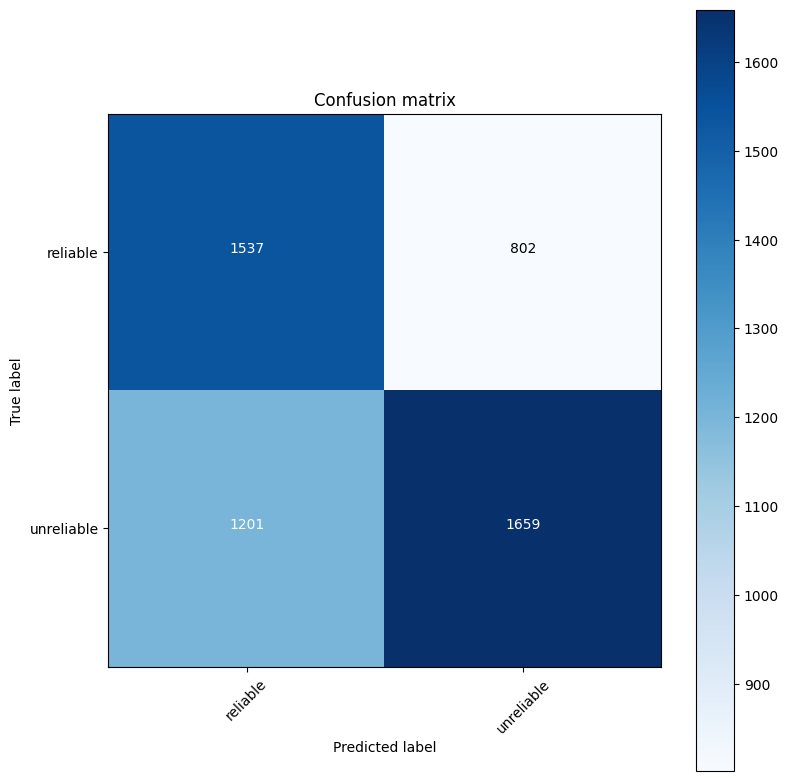

In [31]:
# TODO: THIS y_pred needs to come from the actual testing set (test.csv), NOT the train.csv
X_test = np.array(embedded_docs_test)
Y_test = np.array(labels_test)
y_pred = model.predict(X_test)

print(Y_test)
print(y_pred)

cm = confusion_matrix(Y_test, y_pred.round())

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, ['reliable', 'unreliable'])


In [32]:
# Accuracy
# NOTE: This accuracy is garbage. Training is overfitting in a huge way plus we are not using the proper test set
accuracy = accuracy_score(Y_test, y_pred.round())
print(accuracy)

# Classification Report
classification_report = classification_report(Y_test, y_pred.round())
print(classification_report)

0.6147336026158877
              precision    recall  f1-score   support

           0       0.56      0.66      0.61      2339
           1       0.67      0.58      0.62      2860

    accuracy                           0.61      5199
   macro avg       0.62      0.62      0.61      5199
weighted avg       0.62      0.61      0.62      5199

